# Introduction

This notebook is about Natural Language Processing. Here, we will be using data from kaggle which contains comments from Reddit(https://www.kaggle.com/sherinclaudia/sarcastic-comments-on-reddit). Model needs to classify whether the comment is sarcastic or not. Data contains following features:
    
    Label:- sarcastic or not
    comment:- Reply to a Parent Reddit comment
    Author:- Person who commented
    Subreddit:- Commented under which subreddit
    Score:- Number of upvotes -(minus) Number of downvotes.
    Ups:- Number of upvotes
    Downs:- Number of downvotes
    Date:- Commented date
    Created_utc:- Commented time in the UTC Timezone
    Parent_comment:- The Parent Reddit comment to which sarcastic replies are made

Different models will be used to check which is best fit for this particular data. Deep learning will also be used for comparing LSTM model scores with other models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten
from keras.utils import to_categorical
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("C:/Users/vivek/Downloads/train-balanced-sarcasm.csv")

Data contains around 1.3 million rows so with limited computation power we will be deviding this dataset by half.

In [3]:
df = df.sample(frac=0.3, random_state=42)

In [4]:
df.describe()

,label,score,ups,downs
count,505413.000000,505413.000000,505413.000000,505413.000000
mean,0.499924,6.966774,5.562488,-0.145616
std,0.500000,50.882056,43.002386,0.352721
min,0.000000,-507.000000,-507.000000,-1.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,0.000000
75%,1.000000,4.000000,3.000000,0.000000
max,1.000000,9070.000000,5163.000000,0.000000


In [5]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
608627,1,And he sure as hell is successful!,armiechedon,quityourbullshit,1,1,0,2015-12,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,chess,1,1,0,2016-02,2016-02-13 00:04:43,You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,katawashoujo,5,5,0,2014-12,2014-12-25 21:59:49,That isn't Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,transgender,2,2,0,2012-03,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,AskReddit,28,28,0,2016-09,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505413 entries, 608627 to 92160
Data columns (total 10 columns):
label             505413 non-null int64
comment           505387 non-null object
author            505413 non-null object
subreddit         505413 non-null object
score             505413 non-null int64
ups               505413 non-null int64
downs             505413 non-null int64
date              505413 non-null object
created_utc       505413 non-null object
parent_comment    505413 non-null object
dtypes: int64(4), object(6)
memory usage: 42.4+ MB


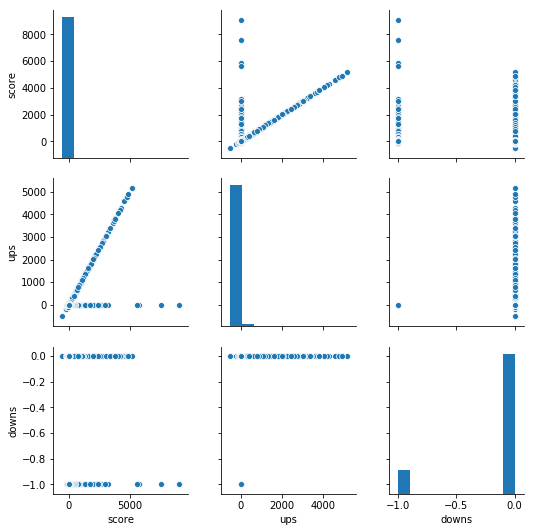

In [8]:
sns.pairplot(df[['score', 'ups', 'downs']])

In [4]:
df.shape

(303248, 10)

Removing all the null values

In [5]:
df=df.dropna()

In [6]:
df.shape

(303234, 10)

### Creating Part Of Speech dataframe

In [15]:
pos_df = pd.DataFrame()

Taking Part Of Speech from every sentence and storing it into different dataframe pos_df

In [16]:
rw=0
for sent in df['comment']:
    tokens=nltk.word_tokenize(sent)
    text = nltk.Text(tokens)
    tagged = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tagged)
    for i in counts.most_common():
        pos_df.loc[rw, i[0]] = i[1]
    rw=rw+1

Remove columns with punctuations

In [17]:
pos_df.columns

Index(['CC', 'PRP', 'RB', 'IN', 'NN', 'VBZ', 'JJ', '.', 'TO', 'VB', 'DT', ',',
       'VBP', 'NNS', 'WRB', 'MD', 'VBN', 'VBD', 'JJS', '(', 'PRP$', ')', 'JJR',
       'VBG', 'NNP', 'RBR', ':', 'POS', 'CD', 'UH', 'WP', 'WDT', 'PDT', '``',
       '''', 'NNPS', 'EX', 'RP', '$', '#', 'FW', 'RBS', 'WP$', 'SYM', 'LS'],
      dtype='object')

In [18]:
pos_df=pos_df.drop(['.', ',', '``', "''", '(', ')', ':', '$', '#'],1)

In [19]:
pos_df.columns

Index(['CC', 'PRP', 'RB', 'IN', 'NN', 'VBZ', 'JJ', 'TO', 'VB', 'DT', 'VBP',
       'NNS', 'WRB', 'MD', 'VBN', 'VBD', 'JJS', 'PRP$', 'JJR', 'VBG', 'NNP',
       'RBR', 'POS', 'CD', 'UH', 'WP', 'WDT', 'PDT', 'NNPS', 'EX', 'RP', 'FW',
       'RBS', 'WP$', 'SYM', 'LS'],
      dtype='object')

In [10]:
pos_df.to_csv('C:/Users/vivek/Downloads/pos.csv')

NameError: name 'pos_df' is not defined

In [20]:
pos_df.to_csv('C:/Users/vivek/Downloads/pos3.csv')

### Loading Part Of Speech dataframe

In [10]:
pos_loaded_df = pd.read_csv('C:/Users/vivek/Downloads/pos.csv')

In [7]:
pos_loaded_df = pd.read_csv('C:/Users/vivek/Downloads/pos3.csv')

In [8]:
pos_loaded_df = pos_loaded_df.fillna(0)

Running PCA on part of speech dataframe

In [9]:
pca = PCA(10)
pos_pca = pca.fit_transform(pos_loaded_df)
print(pos_pca)

[[ 1.51616500e+05 -7.61128641e-01 -6.30917925e-01 ... -2.83761445e-01
  -1.46034865e-01 -8.53093605e-01]
 [ 1.51615500e+05 -7.54616647e-01  1.39582071e+00 ...  4.03112692e-01
   5.61308488e-01  2.08408713e+00]
 [ 1.51614500e+05 -7.61457838e-01  3.73037101e-01 ... -4.67805906e-01
   3.40106825e-01 -2.37060380e-01]
 ...
 [-1.51614500e+05  2.13975086e-01 -1.72083725e+00 ...  6.02611203e-01
  -2.64467943e-01  3.47645683e-01]
 [-1.51615500e+05  2.09673211e-01 -1.73476540e+00 ... -7.66005745e-01
   8.56682314e-01 -5.84257624e-01]
 [-1.51616500e+05  1.21511792e+00 -1.54435909e+00 ...  7.35531952e-02
  -1.11500492e+00 -6.68351144e-01]]


In [10]:
pos_pca_df = pd.DataFrame(pos_pca)

In [11]:
pos_pca_df.index = df.index

In [12]:
pos_pca_df

,0,1,2,3,4,5,6,7,8,9
608627,151616.500000,-0.761129,-0.630918,0.222937,0.353453,0.235507,0.409962,-0.283761,-0.146035,-0.853094
456977,151615.500000,-0.754617,1.395821,-0.642808,-0.163310,0.093172,-0.907329,0.403113,0.561308,2.084087
803801,151614.500000,-0.761458,0.373037,-0.265671,-0.178419,1.454610,-0.034679,-0.467806,0.340107,-0.237060
926708,151613.500000,-0.745755,3.584052,-5.154209,-10.490453,0.197803,3.029354,-4.868224,-0.784526,-0.434862
129279,151612.500000,2.239032,0.402433,-0.554391,-0.533961,1.170023,1.715513,2.285805,-1.691601,0.164498
951335,151611.500000,-0.768255,-1.725251,0.965991,1.450976,-0.356155,0.370146,-0.447141,0.256995,-0.097909
655372,151610.500000,-0.759314,-0.618679,0.230855,0.381738,-1.254519,0.040779,-1.644416,-1.196141,0.427067
632636,151609.500000,4.246648,1.405318,-1.053863,-0.671149,0.104611,-0.757208,1.324996,-0.197571,1.464755
397220,151608.500000,-0.768397,-1.544883,0.318015,-0.141907,0.035002,0.031408,-0.140494,0.182244,-0.678119
412260,151607.500000,-0.765090,-0.558702,-0.053799,-0.344552,0.624242,-0.158696,0.635071,-0.405574,1.765062


### Adding other features to POS dataframe

In [13]:
pos_pca_df['score'] = df['score']
pos_pca_df['ups'] = df['ups']
pos_pca_df['downs'] = df['downs']

In [14]:
pca_added_df = pd.concat([df, pos_pca_df], axis=1)

Converting text data into Tfidf Vector.

In [15]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', min_df=0.0, max_df=1.0)
tfidf_text_vector = tfidf_vectorizer.fit_transform(df['comment'])

Using Latent Dirichlet Allocation to reduce dimensionality of tfidf vector.

In [16]:
lda = LatentDirichletAllocation(n_components=500)
tfidf_lda = lda.fit_transform(tfidf_text_vector)

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:796: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)


In [17]:
Y=df['label']

Doing train-test split for validation

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf_lda, Y)

In [19]:
X_train_pos, X_test_pos, Y_train_pos, Y_test_pos = train_test_split(pos_pca_df, Y)

## Supervised Learning

### RandomForestClassifier with tfidf vector

In [20]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=30)
rfc.fit(X_train, Y_train)
print("Train data score: ", rfc.score(X_train, Y_train))
print("Test data score: ", rfc.score(X_test, Y_test))

Train data score:  0.5008508299439376
Test data score:  0.5009959239668114


### RandomForestClassifier with POS dataframe

In [21]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=30)
rfc.fit(X_train_pos, Y_train_pos)
print("Train data score: ", rfc.score(X_train_pos, Y_train_pos))
print("Test data score: ", rfc.score(X_test_pos, Y_test_pos))

Train data score:  0.5785819500934374
Test data score:  0.5741270825363743


### GradientBoostingClassifier with tfidf vector

In [23]:
gbc = GradientBoostingClassifier(learning_rate=0.3)
gbc.fit(X_train, Y_train)
print("Train data score: ", gbc.score(X_train, Y_train))
print("Test data score: ", gbc.score(X_test, Y_test))

Train data score:  0.5017742112784435
Test data score:  0.500850822461713


### GradientBoostingClassifier with POS dataframe

In [24]:
gbc = GradientBoostingClassifier(learning_rate=0.3)
gbc.fit(X_train_pos, Y_train_pos)
print("Train data score: ", gbc.score(X_train_pos, Y_train_pos))
print("Test data score: ", gbc.score(X_test_pos, Y_test_pos))

Train data score:  0.599837309002968
Test data score:  0.5883206479441755


### LogisticRegression with tfidf vector

In [25]:
lrc = LogisticRegression(penalty='l1')
lrc.fit(X_train, Y_train)
print("Train data score: ", lrc.score(X_train, Y_train))
print("Test data score: ", lrc.score(X_test, Y_test))

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train data score:  0.5004419039243707
Test data score:  0.5009827329208933


### LogisticRegression with POS dataframe

In [26]:
lrc = LogisticRegression(penalty='l2')
lrc.fit(X_train_pos, Y_train_pos)
print("Train data score: ", lrc.score(X_train_pos, Y_train_pos))
print("Test data score: ", lrc.score(X_test_pos, Y_test_pos))

C:\Users\vivek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train data score:  0.5314279432780037
Test data score:  0.5285784009814138


## Deep Learning

In [27]:
deep_df = pca_added_df.sample(frac=0.2, random_state=42)

### LSTM with comment

In [28]:
text = deep_df['comment']
text = text.apply(lambda x: x.lower() if type(x)=='str' else str(x))

In [29]:
print(text)

145147     I'm sorry but at this point if you're being ca...
796203              Sure I'm so worried about them right now
44502      Just wait until your hormones kick in and you'...
349806     Dry cigars are acceptable in a survival situat...
832598                  she *IS* the younger one, after all.
960035                     Yes, that is totally what I said.
912863     Yes it was the Palestinians who crossed contin...
700344                        OH yeah stigmata is sooo sexy!
622606     Wow.. Americans really take care of their vete...
288830        Saving this to repost on valentine's day 2017.
598778     its really too bad Bryant screwed up, the way ...
77109      If they get amnesty for running over pedestria...
403977                                     We did it Reddit!
740713                               Kettle Corn Master Race
746133           You mustn't ever forget the Muller Corners!
937517     I gave an easy one to remember not long in the...
40664               Well

Tokenizing the words with 40000 most common words. It's basically the vocabulary of our model.

In [30]:
batch_size = 40000
tokenizer = Tokenizer(num_words=batch_size, split='(?u)\b\w\w+\b')
tokenizer.fit_on_texts(text.values)
X = tokenizer.texts_to_sequences(text.values)

In [31]:
X = pad_sequences(X)

In [32]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
# converting pos dataframe to numpy array
X_train_pos=X_train_pos.to_numpy()

In [34]:
Y = deep_df['label']
Y = to_categorical(Y)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=87)

In [36]:
embed_dim=128
lstm_out=256
model = Sequential()
model.add(Embedding(batch_size, embed_dim, input_length=X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2, activation='softmax'))

W0723 21:58:33.918729 27252 deprecation_wrapper.py:119] From C:\Users\vivek\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.
W0723 21:58:34.040745 27252 deprecation_wrapper.py:119] From C:\Users\vivek\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 21:58:34.065050 27252 deprecation_wrapper.py:119] From C:\Users\vivek\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 2

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 293, 128)          5120000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 5,514,754
Trainable params: 5,514,754
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0723 21:58:34.488517 27252 deprecation_wrapper.py:119] From C:\Users\vivek\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 21:58:34.512325 27252 deprecation_wrapper.py:119] From C:\Users\vivek\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [39]:
model.fit(X_train, Y_train, epochs=10, batch_size=1000, validation_data=(X_test, Y_test))

W0723 21:58:34.621148 27252 deprecation.py:323] From C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45485 samples, validate on 15162 samples
Epoch 1/10
45485/45485 [==============================] - 586s 13ms/step - loss: 0.6911 - acc: 0.5186 - val_loss: 0.6862 - val_acc: 0.5354
Epoch 2/10
45485/45485 [==============================] - 695s 15ms/step - loss: 0.6592 - acc: 0.6775 - val_loss: 0.6835 - val_acc: 0.5505
Epoch 3/10
45485/45485 [==============================] - 1040s 23ms/step - loss: 0.5126 - acc: 0.7389 - val_loss: 0.6927 - val_acc: 0.5365
Epoch 4/10
45485/45485 [==============================] - 1232s 27ms/step - loss: 0.4182 - acc: 0.7533 - val_loss: 0.7124 - val_acc: 0.5483
Epoch 5/10
45485/45485 [==============================] - 1318s 29ms/step - loss: 0.3796 - acc: 0.7579 - val_loss: 0.7303 - val_acc: 0.5481
Epoch 6/10
45485/45485 [==============================] - 1376s 30ms/step - loss: 0.3688 - acc: 0.7579 - val_loss: 0.7444 - val_acc: 0.5464
Epoch 7/10
45485/45485 [==============================] - 1413s 31ms/step - loss: 0.3641 - acc: 0.7583 - val_los

### Neural network with POS dataframe

In [ ]:
embed_dim=128
lstm_out=256
model2 = Sequential()
model2.add(Dense(200, batch_input_shape=(412, X_train_pos.shape[1], )))
model2.add(Dropout(rate=0.2))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(1, activation='softmax'))
model2.summary()

In [93]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
model2.fit(X_train_pos, Y_train_pos, epochs=5, batch_size=412, validation_split=0.2)

Train on 303232 samples, validate on 75808 samples
Epoch 1/5
303232/303232 [==============================] - 3s 10us/step - loss: 7.9597 - acc: 0.5007 - val_loss: 7.9792 - val_acc: 0.4995
Epoch 2/5
303232/303232 [==============================] - 3s 9us/step - loss: 7.9597 - acc: 0.5007 - val_loss: 7.9792 - val_acc: 0.4995
Epoch 3/5
303232/303232 [==============================] - 3s 9us/step - loss: 7.9597 - acc: 0.5007 - val_loss: 7.9792 - val_acc: 0.4995
Epoch 4/5
303232/303232 [==============================] - 3s 9us/step - loss: 7.9597 - acc: 0.5007 - val_loss: 7.9792 - val_acc: 0.4995
Epoch 5/5
303232/303232 [==============================] - 3s 9us/step - loss: 7.9597 - acc: 0.5007 - val_loss: 7.9792 - val_acc: 0.4995


### LSTM with parent_comment and comment combined

Previously we only used the column comment to get our features but we should also consider parent_comment as it has the context of next sentence. So new data will contain both the sentences seperated by a space. It will go through the same process but with bigger sentences.

In [53]:
all_text = deep_df['parent_comment'] + ' ' + deep_df['comment']
all_text = all_text.apply(lambda x: x.lower() if type(x)=='str' else str(x))

In [54]:
batch_size = 50000
tokenizer = Tokenizer(num_words=batch_size, split='(?u)\b\w\w+\b')
tokenizer.fit_on_texts(all_text.values)
X = tokenizer.texts_to_sequences(all_text.values)

In [55]:
X = pad_sequences(X)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=87)

In [59]:
embed_dim=128
lstm_out=256
model = Sequential()
model.add(Embedding(batch_size, embed_dim, input_length=X_train.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2, activation='softmax'))

C:\Users\vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.


In [60]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=500, validation_data=(X_test, Y_test))

Train on 45485 samples, validate on 15162 samples
Epoch 1/10
45485/45485 [==============================] - 4494s 99ms/step - loss: 0.6869 - acc: 0.5330 - val_loss: 0.6808 - val_acc: 0.5469
Epoch 2/10
45485/45485 [==============================] - 5595s 123ms/step - loss: 1.0866 - acc: 0.5311 - val_loss: 0.6894 - val_acc: 0.5069
Epoch 3/10
45485/45485 [==============================] - 5597s 123ms/step - loss: 0.6623 - acc: 0.6453 - val_loss: 0.6825 - val_acc: 0.5354
Epoch 4/10
45485/45485 [==============================] - 5628s 124ms/step - loss: 0.6183 - acc: 0.6620 - val_loss: 0.6982 - val_acc: 0.5382
Epoch 5/10
45485/45485 [==============================] - 5644s 124ms/step - loss: 0.5614 - acc: 0.6706 - val_loss: 0.7323 - val_acc: 0.5386
Epoch 6/10
45485/45485 [==============================] - 5639s 124ms/step - loss: 0.5249 - acc: 0.6748 - val_loss: 0.7792 - val_acc: 0.5313
Epoch 7/10
45485/45485 [==============================] - 5690s 125ms/step - loss: 0.5117 - acc: 0.6753 -

# Conclusion 

In conclusion, deep learning is best performer with comments data which has accuracy of around 75% in training data and 56% in testing data. We can increase accuracy by adding more vocabulary to the tokenizer but it takes more computational power to create and run such data.